I tried so many experiments on ratios and scales. I did consider ratios and scales are correlevant. So, in that previous experiments I carried out clustering simutaneously 2 that factors (each of that on each coordinate axis). And the results mostly unchaged, even the model witnessed downwards trends in some experiments. Then, I investigated the AnchorGenerator registry of mmdetection, I realize that the boxes generated based on each base_size corresponding to each layer/featmap of FPN, in each layer boxes are in different defined ratios. So, I concluded that ratios and scale should be independent.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans

In [2]:
scratch_data = json.load(open('/mmdetection/data/scratch/annotations/clean_old_scratch.json'))
print(len(scratch_data['images']), len(scratch_data['annotations']))

23473 114285


# create bbox infor of ground truth data

In [3]:
value_list = []

for ann in scratch_data['annotations']:
    for img in scratch_data['images']:
        if img['id'] == ann['image_id']:
            img_w = img['width']
            img_h = img['height']
            break
            
    value = (ann['id'], ann['image_id'], img_w, img_h, ann['bbox'][2], ann['bbox'][3], ann['bbox'][0], ann['bbox'][1])
    value_list.append(value)
    
column_names = ['ann_id', 'img_id', 'img_width', 'img_height', 'box_width', 'box_height', 'xmin', 'ymin']
box_df = pd.DataFrame(value_list, columns = column_names)

box_df.to_csv('./output_data/gt_box_info.csv', index=False)
box_df = pd.read_csv('./output_data/gt_box_info.csv')
print(box_df.describe())


              ann_id         img_id      img_width     img_height  \
count  114285.000000  114285.000000  114285.000000  114285.000000   
mean   179309.909787   35561.124583    1559.091631    1183.264164   
std     74942.384958   14454.881645    1232.582523     891.356810   
min        48.000000      19.000000     200.000000     113.000000   
25%    133222.000000   27317.000000     700.000000     720.000000   
50%    178628.000000   35433.000000    1280.000000     960.000000   
75%    220707.000000   42827.000000    1600.000000    1152.000000   
max    354496.000000   69306.000000   17510.000000   13132.000000   

           box_width     box_height           xmin           ymin  
count  114285.000000  114285.000000  114285.000000  114285.000000  
mean      128.426487      64.405903     715.192714     632.011170  
std       232.316206     108.998063     705.791882     575.523447  
min         1.195392       0.881026       0.000000       0.000000  
25%        22.749092      13.277973   

# resize image according to tensorflow object detection API

In [4]:
min_dimension = 480
max_dimension = 1024
# function from Tensorflow Object Detection API to resize image
def _compute_new_static_size(width, height, min_dimension, max_dimension):
    orig_height = height
    orig_width = width
    orig_min_dim = min(orig_height, orig_width)
  
    # Calculates the larger of the possible sizes
    large_scale_factor = min_dimension / float(orig_min_dim)
      # Scaling orig_(height|width) by large_scale_factor will make the smaller
      # dimension equal to min_dimension, save for floating point rounding errors.
      # For reasonably-sized images, taking the nearest integer will reliably
      # eliminate this error.
    large_height = int(round(orig_height * large_scale_factor))
    large_width = int(round(orig_width * large_scale_factor))
    large_size = [large_height, large_width]
    if max_dimension:
    # Calculates the smaller of the possible sizes, use that if the larger
    # is too big.
        orig_max_dim = max(orig_height, orig_width)
        small_scale_factor = max_dimension / float(orig_max_dim)
    # Scaling orig_(height|width) by small_scale_factor will make the larger
    # dimension equal to max_dimension, save for floating point rounding
    # errors. For reasonably-sized images, taking the nearest integer will
    # reliably eliminate this error.
        small_height = int(round(orig_height * small_scale_factor))
        small_width = int(round(orig_width * small_scale_factor))
        small_size = [small_height, small_width]
        new_size = large_size
    if max(large_size) > max_dimension:
        new_size = small_size
    else:
        new_size = large_size
    
    return new_size[1], new_size[0]

box_df['new_img_w'], box_df['new_img_h'] = np.vectorize(_compute_new_static_size)(box_df['img_width'], box_df['img_height'], min_dimension, max_dimension)
box_df['new_b_w'] = box_df['new_img_w']*box_df['box_width']/box_df['img_width']
box_df['new_b_h'] = box_df['new_img_h']*box_df['box_height']/box_df['img_height']
box_df['new_box_ar'] = box_df['new_b_h']/box_df['new_b_w']
box_df['new_box_area'] = box_df['new_b_w']*box_df['new_b_h']
box_df.describe()

,ann_id,img_id,img_width,img_height,box_width,box_height,xmin,ymin,new_img_w,new_img_h,new_b_w,new_b_h,new_box_ar,new_box_area
count,114285.000000,114285.000000,114285.000000,114285.000000,114285.000000,114285.000000,114285.000000,114285.000000,114285.000000,114285.00000,114285.000000,114285.000000,114285.000000,114285.000000
mean,179309.909787,35561.124583,1559.091631,1183.264164,128.426487,64.405903,715.192714,632.011170,645.838798,507.46503,57.002017,29.351004,0.845022,3662.427903
std,74942.384958,14454.881645,1232.582523,891.356810,232.316206,108.998063,705.791882,575.523447,102.125558,74.84776,80.525196,41.036649,1.078718,12036.021670
min,48.000000,19.000000,200.000000,113.000000,1.195392,0.881026,0.000000,0.000000,472.000000,480.00000,0.914660,0.469394,0.005897,3.713029
25%,133222.000000,27317.000000,700.000000,720.000000,22.749092,13.277973,287.134159,310.912692,640.000000,480.00000,12.199825,7.187743,0.310345,98.385834
50%,178628.000000,35433.000000,1280.000000,960.000000,54.364641,29.707923,510.892244,461.900441,640.000000,480.00000,27.518939,15.039513,0.565370,400.816418
75%,220707.000000,42827.000000,1600.000000,1152.000000,134.265829,69.414586,857.205624,690.878746,640.000000,480.00000,65.319617,33.659324,1.000000,1915.260434
max,354496.000000,69306.000000,17510.000000,13132.000000,5151.886665,2547.129282,13248.717517,11777.406340,1017.000000,1024.00000,986.588571,677.468490,41.509772,407348.289224


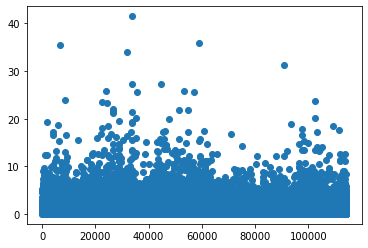

In [27]:
#plot box aspect ratio
AR = (box_df['new_box_ar'].values).reshape(-1,1)

plt.plot(AR, 'o')

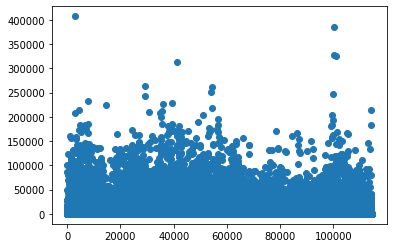

In [28]:
#plot box scale
S = (box_df['new_box_area'].values).reshape(-1,1)
plt.plot(S, 'o')

### clean ar outliers

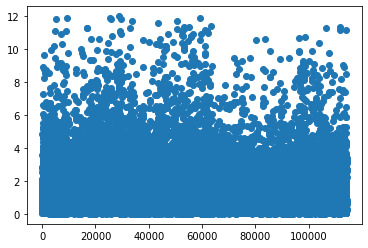

In [35]:
box_ar_filtered = box_df[box_df['new_box_ar']<12]
plt.plot(box_ar_filtered['new_box_ar'].values, 'o')

### clean scale outliers

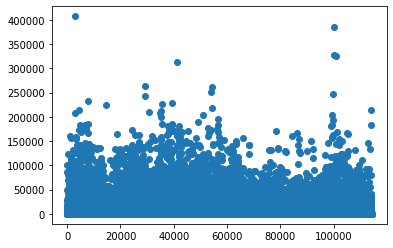

In [36]:
plt.plot(box_ar_filtered['new_box_area'].values, 'o')

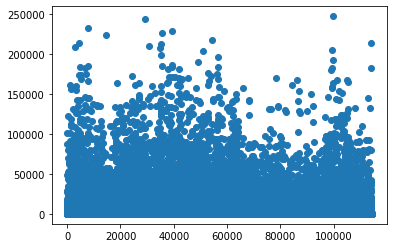

In [37]:
box_ar_scale_filtered = box_ar_filtered[box_ar_filtered['new_box_area']<250000]
plt.plot(box_ar_scale_filtered['new_box_area'].values, 'o')

# cluster box_ar

[[ 1.23485843]
 [ 0.40740022]
 [16.44087155]
 [ 2.85315915]
 [ 6.56536858]]


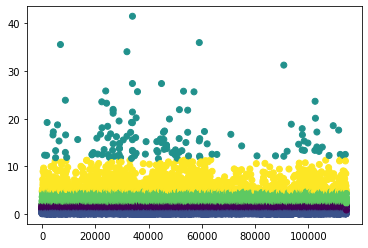

In [45]:
AR = (box_df['new_box_ar'].values).reshape(-1,1)

K = KMeans(5, random_state = 1)
labels = K.fit(AR)
print(labels.cluster_centers_)
plt.scatter(range(len(AR)),AR, c=labels.labels_, cmap='viridis')

### cluster clean ratio

[[0.3434203 ]
 [1.92110634]
 [7.58430032]
 [0.94352366]
 [3.7757587 ]]


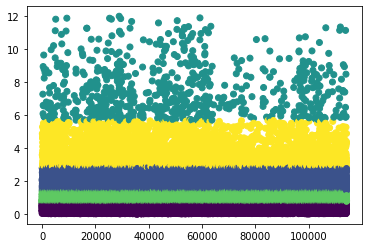

In [46]:
#cach 1: cluster 5 ar, obviously regular kmeans
#v12
AR = (box_ar_scale_filtered['new_box_ar'].values).reshape(-1,1)

K = KMeans(5, random_state = 1)
labels = K.fit(AR)
print(labels.cluster_centers_)
plt.scatter(range(len(AR)),AR, c=labels.labels_, cmap='viridis')

[[0.78317611]
 [3.33879393]
 [0.20926115]
 [1.6726223 ]
 [6.61393795]
 [9.44650379]
 [0.47774664]
 [2.36350967]
 [1.16334484]
 [4.67465383]]


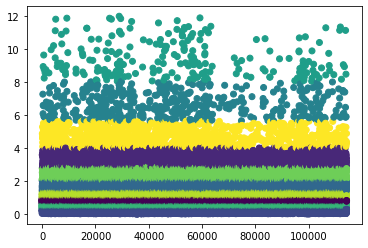

In [185]:
#cach 1: cluster 10 ar, obviously regular kmeans
#v12
AR = (box_ar_scale_filtered['new_box_ar'].values).reshape(-1,1)

ar_K_10 = KMeans(10, random_state = 1)
ar_labels_10 = ar_K_10.fit(AR)
print(ar_labels_10.cluster_centers_)
plt.scatter(range(len(AR)),AR, c=ar_labels_10.labels_, cmap='viridis')

In [116]:
#cach 2: cluster 5 box, regular kmeans
w_h = box_ar_scale_filtered[['new_b_w', 'new_b_h']].values
k = KMeans(5, random_state=1)
labels = k.fit(w_h)
w_h_centers = labels.cluster_centers_
print(w_h_centers)

[[ 85.21132541  45.01704168]
 [ 20.530548    13.93552351]
 [445.96796649 127.45034573]
 [214.08331045  61.00513738]
 [182.55167411 201.54285104]]


In [124]:
w_h_centers = np.array(w_h_centers)
type(w_h_centers)

numpy.ndarray

In [129]:
rat = w_h_centers[:,1]/w_h_centers[:,0]
rat

array([0.52829881, 0.67877017, 0.28578363, 0.2849598 , 1.10403179])

In [ ]:
# ?? 2 cach cho 2 kq khac nhau

#### compare different methods to find area

In [155]:
# cach 1: cluster 15 box to find area (regular kmeans)
w_h = box_ar_scale_filtered[['new_b_w', 'new_b_h']].values
k15 = KMeans(15, random_state=1)
labels15 = k15.fit(w_h)
w_h_centers15 = labels15.cluster_centers_
w_h_centers15 = np.array(w_h_centers15)
print(w_h_centers15)
print(w_h_centers15[:,1]*w_h_centers15[:,0])

[[124.66030421  35.44836891]
 [ 30.8518235   44.60362343]
 [420.56464765  88.34168835]
 [156.0995417  101.00138613]
 [105.79077252 184.78446364]
 [611.20866967 108.25927694]
 [256.98835021 163.15798751]
 [ 36.77498524  14.55094231]
 [ 73.3277483   25.64798769]
 [203.03140183  43.89401552]
 [433.24579128 245.84463301]
 [220.79130207 336.62990031]
 [300.05144081  59.77848759]
 [ 11.7254038    9.20226122]
 [ 71.01580676  86.69325804]]
[  4419.00445233   1376.10311743  37153.39103404  15766.27008559
  19548.49115785  66169.0086351   41929.70203432    535.11068864
   1880.70918595   8911.8635025  106511.15255983  74324.95400399
  17936.62133068    107.90022874   6156.59166022]


In [157]:
area = w_h_centers15[:,1]*w_h_centers15[:,0]
edges = np.sort(np.sqrt(area)).reshape(5,-1)
edges

array([[ 10.38750349,  23.13245963,  37.09586389],
       [ 43.36714408,  66.47559291,  78.46395134],
       [ 94.40266682, 125.56380882, 133.92767201],
       [139.81591883, 192.75214923, 204.76743402],
       [257.23337387, 272.62603325, 326.36046415]])

In [162]:
scales = np.empty([5,3])
for i,row in enumerate(edges):
    scales[i] = np.array([1,row[1]/row[0], row[2]/row[0]])
scales

array([[1.        , 2.22695084, 3.5712011 ],
       [1.        , 1.53285614, 1.80929487],
       [1.        , 1.33008752, 1.41868526],
       [1.        , 1.37861376, 1.46455022],
       [1.        , 1.05983928, 1.26873298]])

In [166]:
print(15*np.array([1,1.3,1.4]))
print(43*np.array([1,1.3,1.4]))
print(94*np.array([1,1.3,1.4]))
print(139*np.array([1,1.3,1.4]))
print(257*np.array([1,1.3,1.4]))

[15.  19.5 21. ]
[43.  55.9 60.2]
[ 94.  122.2 131.6]
[139.  180.7 194.6]
[257.  334.1 359.8]


#cach 2: cell[146] cluster 15 scale, obviously regular kmeans
array([[ 17.42203839,  47.73867169,  74.29923096],
       [ 99.48832747, 124.61509277, 150.68857879],
       [177.56000168, 204.56915853, 232.33506049],
       [262.71101033, 296.21748079, 332.91213971],
       [368.833666  , 410.51744398, 464.46482814]])

In [167]:
ratios15 = w_h_centers15[:,1]/w_h_centers15[:,0]
ratios15

array([0.28435972, 1.44573702, 0.21005496, 0.64703192, 1.74669737,
       0.17712327, 0.63488476, 0.395675  , 0.34977193, 0.21619323,
       0.5674484 , 1.524652  , 0.19922746, 0.78481401, 1.22076003])

In [163]:
# cach 1: cluster 5 box to find area (regular kmeans)
w_h = box_ar_scale_filtered[['new_b_w', 'new_b_h']].values
k5 = KMeans(5, random_state=1)
labels5 = k5.fit(w_h)
w_h_centers5 = labels5.cluster_centers_
w_h_centers5 = np.array(w_h_centers5)
print(w_h_centers5)
print(w_h_centers5[:,1]*w_h_centers5[:,0])

[[ 85.21132541  45.01704168]
 [ 20.530548    13.93552351]
 [445.96796649 127.45034573]
 [214.08331045  61.00513738]
 [182.55167411 201.54285104]]
[ 3835.96178788   286.10393432 56838.77151463 13060.18176382
 36791.98486262]


In [169]:
area5 = w_h_centers5[:,1]*w_h_centers5[:,0]
edges5 = np.sort(np.sqrt(area5)).reshape(5,-1)
edges5

array([[ 16.91460713],
       [ 61.93514178],
       [114.28115227],
       [191.8123689 ],
       [238.40883271]])

In [168]:
ratios5 = w_h_centers5[:,1]/w_h_centers5[:,0]
ratios5

array([0.52829881, 0.67877017, 0.28578363, 0.2849598 , 1.10403179])

# cluster box_scale

mean loss(distance): 1256076248877.6074
[[ 12618.79422739]
 [   897.0004597 ]
 [ 75260.65433314]
 [149527.06186126]
 [ 36346.78653268]]
[[ 56.3339028 ]
 [  4.00446634]
 [335.98506399]
 [667.53152617]
 [162.26243988]]


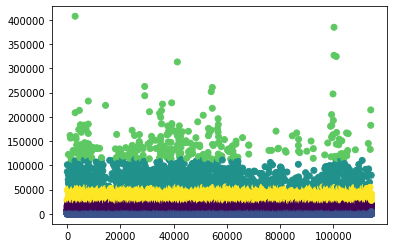

In [47]:
S = (box_df['new_box_area'].values).reshape(-1,1)
K = KMeans(5, random_state = 1)
labels = K.fit(S)
print('mean loss(distance):', labels.inertia_)
center = np.array(labels.cluster_centers_)
print(center)
print(center/224)
plt.scatter(range(len(S)),S, c=labels.labels_, cmap='viridis')

Early stop this experiment, I think there're some prolems with sacales

### cluster clean box_scale

mean loss(distance): 118631679009.21101
[[   303.52742154]
 [ 31527.55419763]
 [110830.4927679 ]
 [ 15528.92134484]
 [ 53979.58033313]
 [168524.57181072]
 [  5520.37572192]
 [ 69017.07494778]
 [  2278.9807752 ]
 [ 22707.04777757]
 [215727.57657667]
 [136038.27317822]
 [  9897.92730264]
 [ 87744.79592506]
 [ 41848.54061964]]
[[  1.35503313]
 [140.74800981]
 [494.77898557]
 [ 69.32554172]
 [240.98026934]
 [752.34183844]
 [ 24.64453447]
 [308.11194173]
 [ 10.17402132]
 [101.37074901]
 [963.06953829]
 [607.31371955]
 [ 44.18717546]
 [391.71783895]
 [186.82384205]]


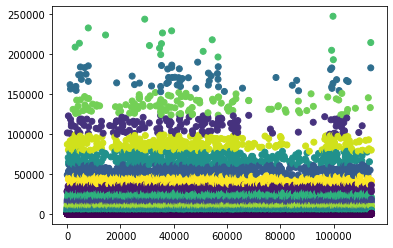

In [145]:
S = (box_ar_scale_filtered['new_box_area'].values).reshape(-1,1)
K = KMeans(15, random_state = 1)
labels = K.fit(S)
print('mean loss(distance):', labels.inertia_)
center = np.array(labels.cluster_centers_)
print(center)
print(center/224)
plt.scatter(range(len(S)),S, c=labels.labels_, cmap='viridis')

In [146]:
center = np.array([i for i in center])
center = np.sort(np.sqrt(center), axis = None)
center

array([ 17.42203839,  47.73867169,  74.29923096,  99.48832747,
       124.61509277, 150.68857879, 177.56000168, 204.56915853,
       232.33506049, 262.71101033, 296.21748079, 332.91213971,
       368.833666  , 410.51744398, 464.46482814])

In [147]:
center= center.reshape(5,-1)
center

array([[ 17.42203839,  47.73867169,  74.29923096],
       [ 99.48832747, 124.61509277, 150.68857879],
       [177.56000168, 204.56915853, 232.33506049],
       [262.71101033, 296.21748079, 332.91213971],
       [368.833666  , 410.51744398, 464.46482814]])

In [144]:
print(30*np.array([1,1.15,1.3]))
print(99*np.array([1,1.15,1.3]))
print(177*np.array([1,1.15,1.3]))
print(262*np.array([1,1.15,1.3]))
print(368*np.array([1,1.15,1.3]))

[30.  34.5 39. ]
[ 99.   113.85 128.7 ]
[177.   203.55 230.1 ]
[262.  301.3 340.6]
[368.  423.2 478.4]


# cluster ar & scale separately on the original scale

In [22]:
box_df['ar'] = box_df['box_height']/box_df['box_width']
box_df['scale'] = box_df['box_height']*box_df['box_width']

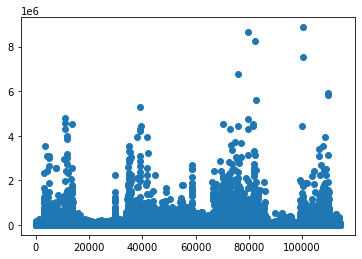

In [29]:
plt.plot(box_df['scale'].values, 'o')

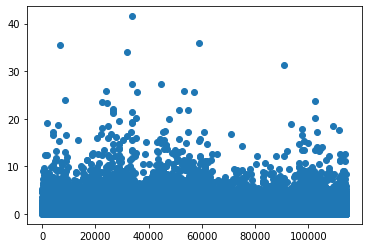

In [30]:
plt.plot(box_df['ar'].values,'o')

In [23]:
AR = (box_df['ar'].values).reshape(-1,1)

K = KMeans(5, random_state = 1)
labels = K.fit(AR)
print(labels.cluster_centers_)

[[ 1.23322792]
 [ 6.55383376]
 [ 2.84812139]
 [ 0.40703136]
 [16.44095407]]


In [24]:
S = (box_df['scale'].values).reshape(-1,1)
K = KMeans(5, random_state = 1)
labels = K.fit(S)
print('mean loss(distance):', labels.inertia_)
center = np.array(labels.cluster_centers_)
print(center)
print(center/224)

mean loss(distance): 236787983682896.75
[[   9592.94707191]
 [2414389.33462792]
 [1057377.83769499]
 [5146502.32216304]
 [ 320589.36074057]]
[[   42.82565657]
 [10778.5238153 ]
 [ 4720.43677542]
 [22975.45679537]
 [ 1431.20250331]]


In [25]:
box_df.to_csv('./output_data/gt_box_info.csv', index=False)


before resizing images, data is divergent, therefore 'scale' clusters' centers are so distant due to centers are so sensitive to outliers

In [ ]:
# plot distribution of image area`

In [31]:
# clean outliers

In [56]:
import math
math.sqrt(1024)

32.0

In [53]:
11.3137*2*2*5.6569

256.00187812

In [55]:
22.6274*2*2*11.3137

1023.9984615200001

In [108]:
(17+47)/(1+1.15)

29.767441860465116

# IoU distance

In [113]:
import numpy as np


def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)


def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

### clean data

In [172]:
#cach 1: cluster 5 box, iou kmeans
boxes = box_ar_scale_filtered[['new_b_w','new_b_h']].values
clusters_5_iou = kmeans(boxes,5)
    
print(clusters_5_iou)

[[ 29.64420076   7.90509664]
 [ 14.85586972  16.8349368 ]
 [159.41268866  77.13603819]
 [  7.5766948    4.9743602 ]
 [ 53.24481296  27.62529241]]


In [173]:
ar5_iou = clusters_5_iou[:,1]/clusters_5_iou[:,0]
ar5_iou

array([0.26666587, 1.13321785, 0.4838764 , 0.65653432, 0.51883537])

In [174]:
edges5_iou = np.sqrt(np.sort(clusters_5_iou[:,1]*clusters_5_iou[:,0]))
edges5_iou

array([  6.13915378,  15.30817663,  15.81447526,  38.35236013,
       110.88941897])

In [175]:
#cach 1: cluster 15 box, iou kmeans
boxes = box_ar_scale_filtered[['new_b_w','new_b_h']].values
clusters_15_iou = kmeans(boxes,15)
    
print(clusters_15_iou)

[[178.6450757   42.37710082]
 [102.49069654  85.38561805]
 [ 10.61339872  19.23847695]
 [271.33785749 137.52945802]
 [ 11.36070493   3.76336422]
 [  6.82233508   7.9558011 ]
 [ 22.44152873  33.59116022]
 [  4.66554124   3.92478129]
 [ 42.05354538  21.05630224]
 [ 92.81767956  21.17647059]
 [ 54.74654378  45.58560291]
 [ 24.44687842  13.74701671]
 [ 54.04696627   9.11316845]
 [ 14.37543404   8.87549255]
 [ 26.51933702   5.3882788 ]]


In [176]:
ar15_iou = clusters_15_iou[:,1]/clusters_15_iou[:,0]
ar15_iou

array([0.23721393, 0.83310604, 1.8126594 , 0.50685687, 0.33126151,
       1.16614048, 1.4968303 , 0.84122743, 0.50070219, 0.22815126,
       0.83266632, 0.56232196, 0.16861573, 0.61740693, 0.20318301])

In [179]:
edges15_iou = np.sqrt(np.sort(clusters_15_iou[:,1]*clusters_15_iou[:,0])).reshape(5,-1)
edges15_iou

array([[  4.27916218,   6.53869027,   7.36730215],
       [ 11.29553265,  11.95381033,  14.28935361],
       [ 18.33225698,  22.19322212,  27.45609199],
       [ 29.75722033,  44.33453351,  49.95652315],
       [ 87.00839261,  93.54801691, 193.17595213]])

In [180]:
scales15_iou = np.empty([5,3])
for i,row in enumerate(edges15_iou):
    scales15_iou[i] = np.array([1,row[1]/row[0], row[2]/row[0]])
scales15_iou

array([[1.        , 1.52803049, 1.7216693 ],
       [1.        , 1.0582777 , 1.26504469],
       [1.        , 1.21061046, 1.49769295],
       [1.        , 1.48987483, 1.67880342],
       [1.        , 1.07516084, 2.22019907]])

In [181]:
print(4*np.array([1,1.2, 1.4]))
print(11*np.array([1,1.2, 1.4]))
print(18*np.array([1,1.2, 1.4]))
print(29*np.array([1,1.2, 1.4]))
print(87*np.array([1,1.2, 1.4]))

[4.  4.8 5.6]
[11.  13.2 15.4]
[18.  21.6 25.2]
[29.  34.8 40.6]
[ 87.  104.4 121.8]


### original data

In [182]:
origin_boxes = box_df[['box_width','box_height']].values
ori_clusters_5_iou = kmeans(origin_boxes,5)
print(ori_clusters_5_iou)
ori_ar5_iou = ori_clusters_5_iou[:,1]/ori_clusters_5_iou[:,0]
ori_area5_iou = ori_clusters_5_iou[:,1]*ori_clusters_5_iou[:,0]
ori_edge5_iou = np.sqrt(np.sort(ori_area5_iou))
print('ar',ori_ar5_iou)
print('edge', ori_edge5_iou)

[[ 29.0762078   15.15268226]
 [157.60603981  76.13787081]
 [437.36934533 215.70288583]
 [ 60.99656829  36.27844584]
 [ 10.41378428   7.66016313]]
ar [0.52113681 0.4830898  0.49318245 0.59476208 0.7355792 ]
edge [  8.93147728  20.99005808  47.04105334 109.54354521 307.15115165]


In [183]:
origin_boxes = box_df[['box_width','box_height']].values
ori_clusters_15_iou = kmeans(origin_boxes,15)
print(ori_clusters_15_iou)
ori_ar15_iou = ori_clusters_15_iou[:,1]/ori_clusters_15_iou[:,0]
ori_area15_iou = ori_clusters_15_iou[:,1]*ori_clusters_15_iou[:,0]
ori_edge15_iou = np.sqrt(np.sort(ori_area15_iou))
print('ar',ori_ar15_iou)
print('edge', ori_edge15_iou)

[[  6.87635666   5.49728829]
 [ 10.32403925  12.90901515]
 [701.02380402 339.19560741]
 [ 18.92140026   6.55761743]
 [ 94.83974364 109.94562799]
 [ 82.37576193  13.85635359]
 [ 38.23103009  10.1717723 ]
 [231.18224841 180.70306066]
 [ 25.53586993  44.55528854]
 [177.64765921  61.37334173]
 [ 21.17078484  18.59880641]
 [ 45.57635396  25.32467532]
 [ 64.44915912  51.89619618]
 [410.68239544  91.68709771]
 [121.91461697  29.35283328]]
ar [0.79944781 1.25038416 0.48385747 0.34657147 1.159278   0.16820911
 0.26606064 0.78164765 1.74481185 0.34547791 0.87851284 0.55565382
 0.80522689 0.22325549 0.2407655 ]
edge [  6.14827739  11.13908902  11.54440033  19.71997294  19.84316831
  33.73066932  33.7850216   33.9736128   57.83308919  59.82089457
 102.11373646 104.41661983 194.04709974 204.39016575 487.631208  ]


In [184]:
ori_edge15_iou = ori_edge15_iou.reshape(5,-1)
ori_scales15_iou = np.empty([5,3])
for i,row in enumerate(ori_edge15_iou):
    ori_scales15_iou[i] = np.array([1,row[1]/row[0], row[2]/row[0]])
ori_scales15_iou

array([[1.        , 1.81174145, 1.8776642 ],
       [1.        , 1.00624724, 1.71048254],
       [1.        , 1.00558209, 1.71179672],
       [1.        , 1.70699113, 1.74548744],
       [1.        , 1.05330183, 2.51295283]])